# Connecting initiators to jets & distinguish quark/gluon jets

Per event, the four-vector is given of the initiator partons. This information is stored into the .root file that is output by .runSoftDropSkinny. The structure is slightly different from the Recursive SoftDrop observables: per event there are 2 entries for each of the four-vector variables i.o. a number of entries corresponding to the number of splittings for each jet. This will give issues when extracting the data. This is solved by splitting the data into data of the partons and data of the jets (SoftDropped). \
Structure of jets: event -> jet -> jetentry \
Sturcuture of partons: event -> partonentry (almost always 2)

Next the four-vectors of the partons should be used to obtain a form of distance (like dr12?) for the partons. These can then be compared to the jets, and a link can be made between the partons and their corresponding jets: the initiators are the first partons to form jets, so it is nice to know which jets correspond to these. 

In [9]:
import ROOT
import uproot

import math as m
import numpy as np
import scipy as sp
import pandas as pd
import awkward as ak

import matplotlib.pyplot as plt
from matplotlib import colors

SyntaxError: invalid syntax (3046428259.py, line 11)

In [ ]:
fileName = "samples/07-09-2021_58MB_Pt120_tune14_10k_SD/JetToyHIResultSoftDropSkinny.root"
branches = uproot.open(fileName)['jetTreeSig'].arrays()

In [ ]:
df = ak.to_pandas(branches)
df.head()

eventWeight    sigJetPt  sigJetEta  sigJetPhi  \
entry subentry subsubentry                                                  
0     0        0                    1.0  129.194639  -2.181834   6.021922   
               1                    1.0  129.194639  -2.181834   6.021922   
               2                    1.0  129.194639  -2.181834   6.021922   
               3                    1.0  129.194639  -2.181834   6.021922   
               4                    1.0  129.194639  -2.181834   6.021922   

                             sigJetM  sigJetArea  p1_jet_dR  p2_jet_dR  \
entry subentry subsubentry                                               
0     0        0            8.420125    0.513286   3.614601   0.026881   
               1            8.420125    0.513286   3.614601   0.026881   
               2            8.420125    0.513286   3.614601   0.026881   
               3            8.420125    0.513286   3.614601   0.026881   
               4            8.420125    0.513286   3.614601   0.026881   

                            sigJetRecur_nSD  sigJetRecur_dr12  \
entry subentry subsubentry                                      
0     0        0                        5.0          0.038962   
               1                        5.0          0.021944   
               2                        5.0          0.011159   
               3                        5.0          0.005370   
               4                        5.0          0.002930   

                            sigJetRecur_jetpt  sigJetRecur_z  partonsPt  \
entry subentry subsubentry                                                
0     0        0                   113.679328       0.391057  126.12564   
               1                    69.229175       0.439470  126.12564   
               2                    38.807065       0.131936  126.12564   
               3                    33.687262       0.182258  126.12564   
               4                    27.547556       0.227172  126.12564   

                            partonsEta  partonsPhi  partonsM  partonsPDG  
entry subentry subsubentry                                                
0     0        0             -0.348964    2.855384  0.000001          21  
               1             -0.348964    2.855384  0.000001          21  
               2             -0.348964    2.855384  0.000001          21  
               3             -0.348964    2.855384  0.000001          21  
               4             -0.348964    2.855384  0.000001          21

In [ ]:

jet_data = ak.to_pandas(branches[['sigJetPt', 'sigJetEta', 'sigJetPhi', 'sigJetM', 'sigJetArea', 'p1_jet_dR', 'p2_jet_dR', 'sigJetRecur_nSD']])
jetRec_data = ak.to_pandas(branches[['sigJetRecur_dr12', 'sigJetRecur_jetpt', 'sigJetRecur_z']])
parton_data = ak.to_pandas(branches[['partonsPt', 'partonsEta', 'partonsPhi', 'partonsM', 'partonsPDG']])

# add partonsPDG to the jet data
jet_data['partonsPDG'] = np.nan
#jetRec_data['partonsPDG'] = np.nan

print(jetRec_data.head())
print(jet_data.head())
print(parton_data.tail())

size = jet_data.index[-1][0] + 1

#gluon_jets = flattened_set[ak.flatten(branches['partonsPDG']) == 21]

                            sigJetRecur_dr12  sigJetRecur_jetpt  sigJetRecur_z
entry subentry subsubentry                                                    
0     0        0                    0.038962         113.679328       0.391057
               1                    0.021944          69.229175       0.439470
               2                    0.011159          38.807065       0.131936
               3                    0.005370          33.687262       0.182258
               4                    0.002930          27.547556       0.227172
                  sigJetPt  sigJetEta  sigJetPhi    sigJetM  sigJetArea  \
entry subentry                                                            
0     0         129.194639  -2.181834   6.021922   8.420125    0.513286   
      1          87.500972   0.008960   2.739309  16.517970    0.498336   
      2          37.844921   1.509155   3.173431   6.680464    0.488369   
1     0         405.069079   0.044764   3.528266  44.034188    0.508303 

## Distance between objects

Distance can be calculated using: $$\Delta R^{(detector)}_{ij} = \sqrt{(\phi_i − \phi_j)^2 + (\eta_i − \eta_j)^2}$$

This is defined in the following function:

In [ ]:
def DR(phi_i, phi_j, eta_i, eta_j):
    return m.sqrt((phi_i- phi_j)**2 + (eta_i - eta_j)**2)

Now we can calcluate distances using the four-vectors of two different objects, e.g. partons & jets.
This is then used to find the jets which are closest to the parton initiators. The four-vectors of the parton initiators have been provided in the dataset. 

For each parton we want to find the the jet that minimizes $\Delta R^{(detector)}_{ij}$. This observable will be determined for the parent parton of each jet of an event (the first entry in the jet's binary tree), since this can be seen as the origin of the jet. Linking the jets to the parton initiators we end up with sets of jets from which we now know the parent particle, since this has been given in the parton data: 1-6 quarks, 21 gluons, etc. 

Question: Should we use data for which a zcut has not been applied (zc = 0)? Sometimes the first splittings of jets are removed from the binary tree due to them being soft-scattering processes. However, we want to use the true origin of the jet, which might have been cut out of a dataset where a zcut is applied (this happens quite often). On the other hand, these initial soft-scattering processes would not affect $\phi$ or $\eta$ too much, most likely still linking the parton to the correct jet.
Answer: Simply using the non-recursive without zcut will give the real parent parton for each jet. Then a zcut can still be applied to the recursive softdrop algorithm

Update: Don't need to calculate dR anymore since this is now already done in the .runSoftDropSkinny script. The dRs wrt the partons are given for each jet in the new 

I will now go over the entire dataset, to figure out which jet belongs to which parton initiator.
In principle, the jet that gives the smallest $\Delta R$ for a parton initiator will be linked to that parton. However, in some cases this will not produce correct results. 
For instance, sometimes the reconstruction of the correct jet could not be done correctly (or the reconstruction algorithm skipped the jet?) and the jet will be missing from the dataset. This will result in an event with only 1 jet entry, or multiple jet entries but none of the jets corresponding to one of the particles (the other jets are offsprings of the first) which result in deltaR values higher than $\pi$ for one of the particles.

So a few checks need to be made:
- The event contains at least 2 partons (Not necessary? There seem to be always at least 2 particles, as expected from Pythia)
- The event contains more than 2 partons? (can this even happen?)
- The event contains at least 2 jets (Not necessary? Since I check for dR values < $\pi$ I expect to remove this effect)
- Both partons of the event will have $\Delta R$s smaller than $\pi$ with at least 1 of the jets of the event
- This cannot be the same jet!

In [ ]:
p1_jet_nrs = np.zeros(size)
p2_jet_nrs = np.zeros(size)

p1_dRs = np.zeros(size)
p2_dRs = np.zeros(size)

def check_dR(dRs):
    if any(i <= m.pi for i in dRs):
        return np.argmin(dRs), np.min(dRs)
    elif any()
    else:
        return -1, -1


for iev in range(size):
    # obtain jet index numbers and correspond deltaR, store these in the arrays
    p1_jet_nr, p1_dR = check_dR(jet_data['p1_jet_dR'][iev])
    p2_jet_nr, p2_dR = check_dR(jet_data['p2_jet_dR'][iev])
    p1_jet_nrs[iev], p1_dRs[iev] = p1_jet_nr, p1_dR
    p2_jet_nrs[iev], p2_dRs[iev] = p2_jet_nr, p2_dR


    # pass partonsPDG value onto the jet_data dataframe
    # parton 1
    if p1_jet_nr == -1:
        pass
    else:
        jet_data['partonsPDG'][iev][p1_jet_nr] = parton_data['partonsPDG'][iev][0]

    # parton 2
    if p2_jet_nr == -1:
        pass
    else:
        jet_data['partonsPDG'][iev][p2_jet_nr] = parton_data['partonsPDG'][iev][1]


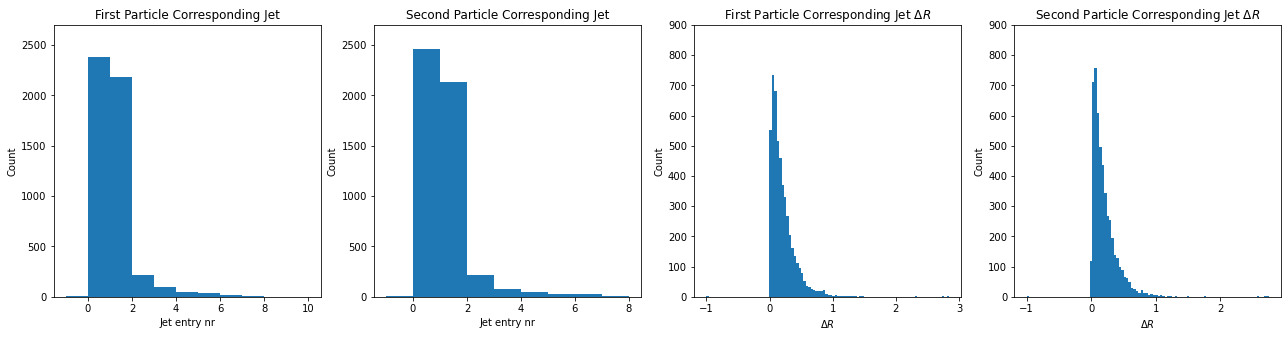

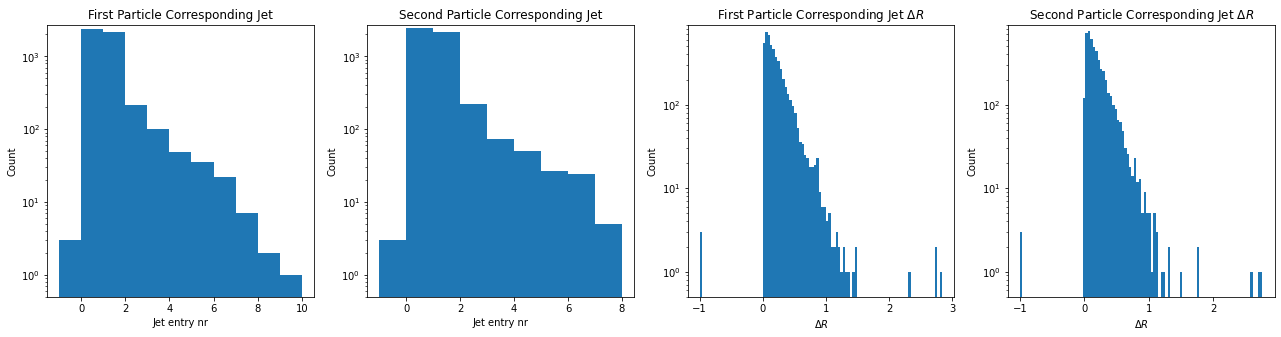

In [ ]:
def plot_dR_info(axs):
    axs[0].hist(p1_jet_nrs, bins=int(np.max(p1_jet_nrs)- np.min(p1_jet_nrs)))
    axs[0].title.set_text('First Particle Corresponding Jet')
    axs[0].set_xlabel('Jet entry nr')
    axs[0].set_ylabel('Count')
    axs[0].set_ylim(top=2700)
    axs[1].hist(p2_jet_nrs, bins=int(np.max(p2_jet_nrs)- np.min(p2_jet_nrs)))
    axs[1].title.set_text('Second Particle Corresponding Jet')
    axs[1].set_xlabel('Jet entry nr')
    axs[1].set_ylabel('Count')
    axs[1].set_ylim(top=2700)
    axs[2].hist(p1_dRs, bins=100)
    axs[2].title.set_text(r'First Particle Corresponding Jet $\Delta R$')
    axs[2].set_xlabel(r'$\Delta R$')
    axs[2].set_ylabel('Count')
    axs[2].set_ylim(top=900)
    axs[3].hist(p2_dRs, bins=100)
    axs[3].title.set_text(r'Second Particle Corresponding Jet $\Delta R$')
    axs[3].set_xlabel(r'$\Delta R$')
    axs[3].set_ylabel('Count')
    axs[3].set_ylim(top=900)
    return

fig, axs = plt.subplots(1, 4, figsize=(22, 5))
fig.patch.set_facecolor('white')
plot_dR_info(axs)
plt.show()

fig2, axs2 = plt.subplots(1, 4, figsize=(22, 5))
fig2.patch.set_facecolor('white')
[ax.set_yscale('log') for ax in axs2]
[ax.set_ylim(bottom=0.5) for ax in axs2]
plot_dR_info(axs2)
plt.show()

In [ ]:
jet_data

sigJetPt  sigJetEta  sigJetPhi    sigJetM  sigJetArea  \
entry subentry                                                            
0     0         129.194639  -2.181834   6.021922   8.420125    0.513286   
      1          87.500972   0.008960   2.739309  16.517970    0.498336   
      2          37.844921   1.509155   3.173431   6.680464    0.488369   
1     0         405.069079   0.044764   3.528266  44.034188    0.508303   
      1         281.747158  -1.467919   0.145335  34.143812    0.518269   
...                    ...        ...        ...        ...         ...   
4998  3          10.852347   2.280452   0.114756   3.213155    0.508303   
4999  0         186.120007  -0.082260   0.501136  27.490453    0.498336   
      1         155.157510  -1.784510   3.523794  16.089742    0.488369   
      2          28.351352   1.757114   4.695808   6.473992    0.498336   
      3          15.912896  -0.307280   3.238701   2.654845    0.503319   

                p1_jet_dR  p2_jet_dR  sigJetRecur_nSD  partonsPDG  
entry subentry                                                     
0     0          3.614601   0.026881              5.0         2.0  
      1          0.376127   3.739993              5.0        21.0  
      2          1.871449   4.642411              3.0         NaN  
1     0          0.192382   3.371172              9.0        21.0  
      1          3.276137   0.337545              5.0        21.0  
...                   ...        ...              ...         ...  
4998  3          4.332422   1.012950              2.0         NaN  
4999  0          0.146278   3.427155              5.0        21.0  
      1          3.577362   0.051086              4.0         1.0  
      2          2.631492   3.664391              6.0         NaN  
      3          2.888389   1.453442              2.0         NaN  

[21477 rows x 9 columns]

In [ ]:
print('Gluon jets:', np.count_nonzero(jet_data['partonsPDG'] == 21) )
print('Quark jets:', np.count_nonzero(np.abs(jet_data['partonsPDG']).isin(range(1,7))) )

Gluon jets: 5921
Quark jets: 4073


In [ ]:
g_jets = jet_data[jet_data['partonsPDG'] == 21 ]
q_jets = jet_data[np.abs(jet_data['partonsPDG'].isin(range(1,7)))]

# apply pt cut, eta cut - ignore the UserWarning, because the result is exactly what we want
cg_jets = g_jets[jet_data['sigJetEta'] <= 2][jet_data['sigJetEta'] >= -2][jet_data['sigJetPt'] >= 130]
cq_jets = q_jets[jet_data['sigJetEta'] <= 2][jet_data['sigJetEta'] >= -2][jet_data['sigJetPt'] >= 130]

/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_4524/3890901418.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cg_jets = g_jets[jet_data['sigJetEta'] <= 2][jet_data['sigJetEta'] >= -2][jet_data['sigJetPt'] >= 130]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_4524/3890901418.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cq_jets = q_jets[jet_data['sigJetEta'] <= 2][jet_data['sigJetEta'] >= -2][jet_data['sigJetPt'] >= 130]


In [ ]:
print('Gluon jets:', len(g_jets))
print('Quark jets:', len(q_jets))
print('Gluon jets after cuts:', len(cg_jets))
print('Quark jets after cuts:', len(cq_jets))

print('Cut Survival rate Gluon / Survival rate Quark:', (len(cg_jets)/ len(g_jets)) / (len(cq_jets)/len(q_jets)))

Gluon jets: 5921
Quark jets: 3266
Gluon jets after cuts: 2336
Quark jets after cuts: 1513
Cut Survival rate Gluon / Survival rate Quark: 0.8516379967880686


In [ ]:
g_jets

sigJetPt  sigJetEta  sigJetPhi    sigJetM  sigJetArea  \
entry subentry                                                            
0     1          87.500972   0.008960   2.739309  16.517970    0.498336   
1     0         405.069079   0.044764   3.528266  44.034188    0.508303   
      1         281.747158  -1.467919   0.145335  34.143812    0.518269   
2     0         177.368018  -0.682919   1.728660  18.506593    0.513286   
      1         153.779092   0.973012   4.879201  25.869341    0.523253   
...                    ...        ...        ...        ...         ...   
4995  4          25.679363   1.340074   0.558853   7.991155    0.523253   
4997  4          17.503952  -1.646489   1.753496   6.734868    0.503319   
4998  0         104.062293  -0.973557   3.309302  18.595377    0.493353   
      1          58.333450   0.803685   0.225309   7.065010    0.498336   
4999  0         186.120007  -0.082260   0.501136  27.490453    0.498336   

                p1_jet_dR  p2_jet_dR  sigJetRecur_nSD  partonsPDG  
entry subentry                                                     
0     1          0.376127   3.739993              5.0        21.0  
1     0          0.192382   3.371172              9.0        21.0  
      1          3.276137   0.337545              5.0        21.0  
2     0          0.131728   3.561669              6.0        21.0  
      1          3.595395   0.077851              6.0        21.0  
...                   ...        ...              ...         ...  
4995  4          0.317784   3.754497              3.0        21.0  
4997  4          0.300564   3.051427              4.0        21.0  
4998  0          0.212976   3.772765              4.0        21.0  
      1          3.394787   0.445814              6.0        21.0  
4999  0          0.146278   3.427155              5.0        21.0  

[5921 rows x 9 columns]

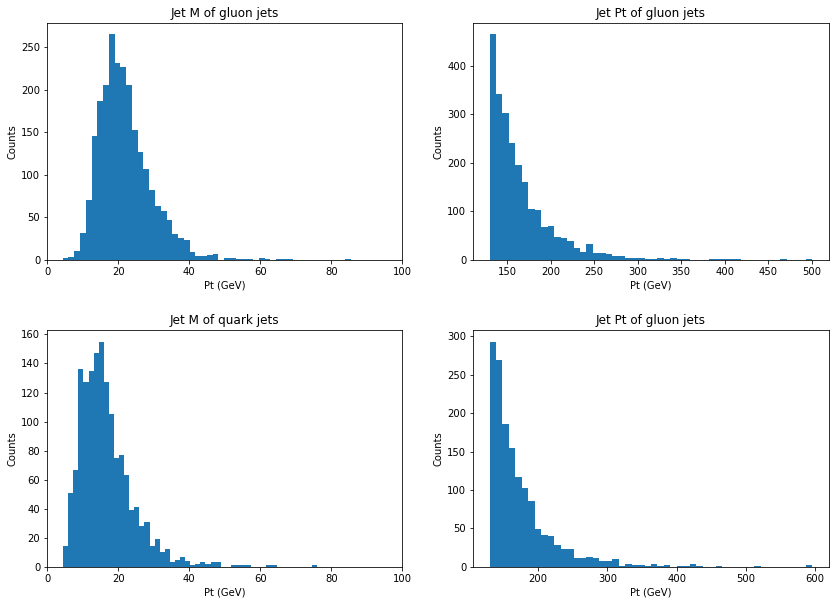

In [ ]:
fig3, axs3 = plt.subplots(2,2, figsize=(14, 10))
fig3.patch.set_facecolor('white')
fig3.subplots_adjust(hspace=0.3)

axs3[0,0].hist(cg_jets['sigJetM'], bins=50)
axs3[0,0].title.set_text("Jet M of gluon jets")
axs3[0,0].set_xlim((0,100))

axs3[0,1].hist(cg_jets['sigJetPt'], bins=50)
axs3[0,1].title.set_text("Jet Pt of gluon jets")

axs3[1,0].hist(cq_jets['sigJetM'], bins=50)
axs3[1,0].title.set_text("Jet M of quark jets")
axs3[1,0].set_xlim((0,100))

axs3[1,1].hist(cq_jets['sigJetPt'], bins=50)
axs3[1,1].title.set_text("Jet Pt of gluon jets")

[[ax.set_ylabel("Counts") for ax in ax_array]for ax_array in axs3]
[[ax.set_xlabel("Pt (GeV)") for ax in ax_array] for ax_array in axs3]

plt.tight_layout
plt.show()


In [ ]:
# Not necessary, we can just apply cuts to jetRec_data with jet_data['partonsPDG']
#jetRec_data['partonsPDG'] = jet_data['partonsPDG']

## Now for the Recursive SoftDropped data

We can simply use the data from jet_data to apply cuts to jetRec_data.
e.g. <br><br>
jetRec_data[jet_data['sigJetPt'] >= 130] <br><br>
works!

In [ ]:
jetRec_data.head(20)

sigJetRecur_dr12  sigJetRecur_jetpt  sigJetRecur_z
entry subentry subsubentry                                                    
0     0        0                    0.038962         113.679328       0.391057
               1                    0.021944          69.229175       0.439470
               2                    0.011159          38.807065       0.131936
               3                    0.005370          33.687262       0.182258
               4                    0.002930          27.547556       0.227172
      1        0                    0.123285          82.121450       0.133018
               1                    0.088098          70.639097       0.129332
               2                    0.038919          61.505219       0.179104
               3                    0.031718          50.494682       0.267085
               4                    0.009094          37.008719       0.215643
      2        0                    0.100337          33.742780       0.276364
               1                    0.065400          24.438433       0.182952
               2                    0.019838          18.486101       0.337223
1     0        0                    0.147428         394.769860       0.300883
               1                    0.132673         276.618416       0.289236
               2                    0.070987         173.863196       0.255452
               3                    0.034476         115.932638       0.273700
               4                    0.022952          84.210576       0.453807
               5                    0.015130          45.998157       0.160921
               6                    0.010784          38.596652       0.320538

### Filters and Cuts, a little explanation

Filter out the quark and gluon jets from the recursive SoftDropped dataset. These are then stored in two new datasets to be used to find the Lund planes. Afterwards, filters for Eta and Pt are applied again on the original quars & gluons data and recursive jetPt data. Should filter be done for sigJetPt instead?

The filters can be applied in this way, because any cuts to the quarks and gluons data are on a jet basis, and the entire jet will be filtered out of the recursive jet dataset. However, the warnings will be output stating that the Boolean Series key will be reindexed to match DataFrame index. I did not find a way to get rid of the warning, however what the warning states is actually exactly what we want... good job Pandas!

In [ ]:
# filter quark and gluon recursive SoftDropped dataset using the normal jet_data set
gR_jets = jetRec_data[jet_data['partonsPDG'] == 21]
qR_jets = jetRec_data[np.abs(jet_data['partonsPDG'].isin(range(1,7)))]

# apply pt cut, eta cut
cgR_jets = gR_jets[(g_jets['sigJetEta'] <= 2) & (g_jets['sigJetEta'] >= -2) & (jetRec_data['sigJetRecur_jetpt'] >= 130)]
cqR_jets = qR_jets[(q_jets['sigJetEta'] <= 2) & (q_jets['sigJetEta'] >= -2) & (jetRec_data['sigJetRecur_jetpt'] >= 130)]

/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_4524/2361331058.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gR_jets = jetRec_data[jet_data['partonsPDG'] == 21]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_4524/2361331058.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  qR_jets = jetRec_data[np.abs(jet_data['partonsPDG'].isin(range(1,7)))]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_4524/2361331058.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cgR_jets = gR_jets[(g_jets['sigJetEta'] <= 2) & (g_jets['sigJetEta'] >= -2) & (jetRec_data['sigJetRecur_jetpt'] >= 130)]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_4524/2361331058.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cqR_jets = qR_jets[(q_jets['sigJetEta'] <= 2) & (q_jets['sigJetEta'] >= -2) & (jetRec_data['sigJetRecur_jetpt'] >= 130)]

In [ ]:
print('Gluon jet constituents', len(gR_jets))
print('Quark jet constituents:', len(qR_jets))
print('Gluon jet constituents after cuts:', len(cgR_jets))
print('Quark jet constituents after cuts:', len(cqR_jets))


Gluon jet constituents 28473
Quark jet constituents: 11971
Gluon jet constituents after cuts: 2176
Quark jet constituents after cuts: 1527


## Lund planes of quark and gluon jets

Apply knowledge of anAliPy_lund.ipynb in order to build and compare Lund planes of the quark and gluon jet's leading branch. 
The Lund planes will be made for both the full recursive quark/gluon dataset (with only a zcut of 0.1 which was already applied when SoftDrop ran) as well as for cuts applied to $\eta$ and $P_T$.

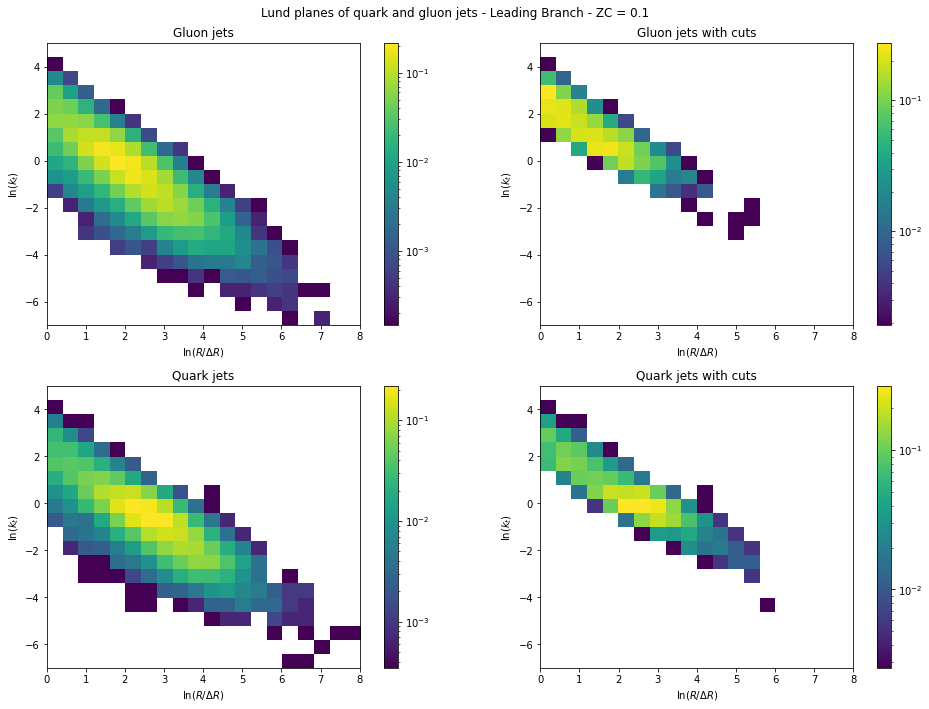

In [ ]:
fig4, axs4 = plt.subplots(2,2, figsize=(14, 10))
fig4.patch.set_facecolor('white')
fig4.subplots_adjust(hspace=0.3)
fig4.suptitle('Lund planes of quark and gluon jets - Leading Branch - ZC = 0.1')

titles = ['Gluon jets', 'Gluon jets with cuts', 'Quark jets', 'Quark jets with cuts']

for i, jetset in enumerate([gR_jets, cgR_jets, qR_jets, cqR_jets]):
    kts = jetset['sigJetRecur_z'] * jetset['sigJetRecur_jetpt'] * jetset['sigJetRecur_dr12']
    H, xedges, yedges = np.histogram2d(np.log(0.4/jetset['sigJetRecur_dr12']), np.log(kts), range=[[0, 8], [-7, 5]], bins=20, normed=True)
    im = axs4[int(i/2), i%2].imshow(H.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges[0], xedges[-1],
            yedges[0], yedges[-1]], aspect=0.6)
    fig.colorbar(im, ax=axs4[int(i/2), i%2])
    axs4[int(i/2), i%2].set_xlabel(r'$\ln (R/\Delta R)$')
    axs4[int(i/2), i%2].set_ylabel(r'$\ln (k_t)$')
    axs4[int(i/2), i%2].title.set_text(titles[i])

plt.tight_layout()
plt.show()

## Number of splittings per gluon or quark jet

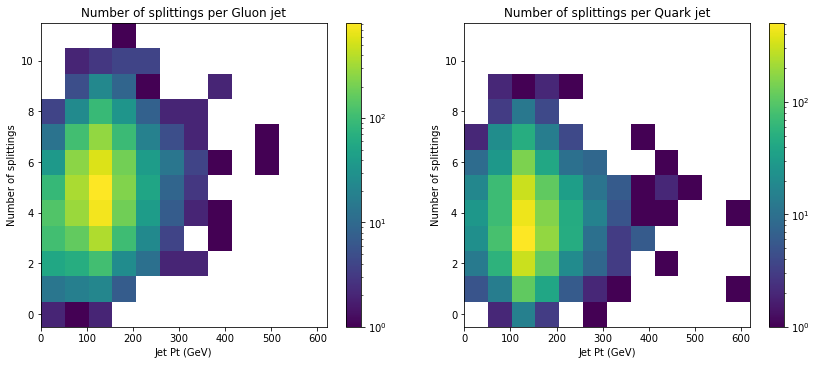

In [ ]:
fig5, axs5 = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12, 5))
fig5.patch.set_facecolor('white')

for i, (jetset, title) in enumerate(zip([g_jets, q_jets], ['Gluon', 'Quark'])):
    
    H, xedges, yedges = np.histogram2d(jetset['sigJetPt'], jetset['sigJetRecur_nSD'],range=[[0,620],[-0.5,11.5]], bins=12)
    im5 = axs5[i].imshow(H.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            aspect=55)
    fig.colorbar(im5, ax=axs5[i])
    axs5[i].title.set_text('Number of splittings per {} jet'.format(title))
    axs5[i].set_xlabel('Jet Pt (GeV)')
    axs5[i].set_ylabel('Number of splittings')
    axs5[i].set_xlim(right=620)
    axs5[i].yaxis.set_tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

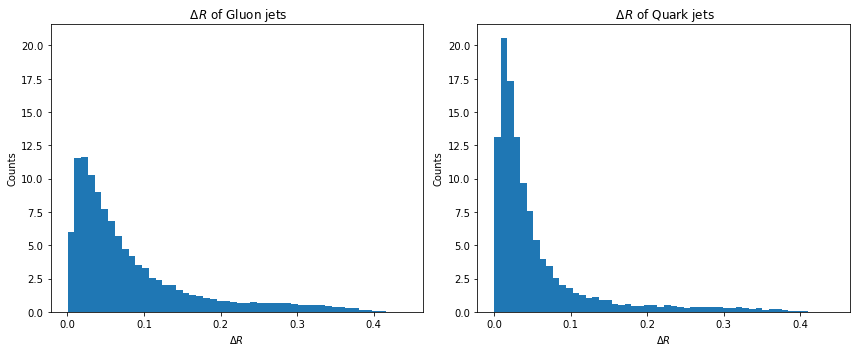

In [ ]:
fig6, axs6 = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12, 5))
fig6.patch.set_facecolor('white')

for i, (jetset, title) in enumerate(zip([gR_jets, qR_jets], ['Gluon', 'Quark'])):
    axs6[i].hist(jetset['sigJetRecur_dr12'], bins=50, density=True)
    axs6[i].title.set_text(r' $\Delta R$ of {} jets'.format(title))
    axs6[i].set_xlabel(r'$\Delta R$')
    axs6[i].set_ylabel('Counts')
    #axs6[i].set_xlim(right=620)
    axs6[i].yaxis.set_tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

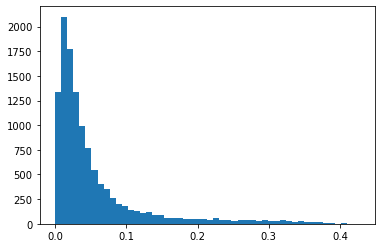

In [ ]:
plt.hist(qR_jets['sigJetRecur_dr12'], bins=50)
plt.show()

In [ ]:
plt.hist(q_jets)